<a href="https://colab.research.google.com/github/entruv/MiniFold/blob/master/03_10_2020_Small_Model_learn_legal_moves_chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

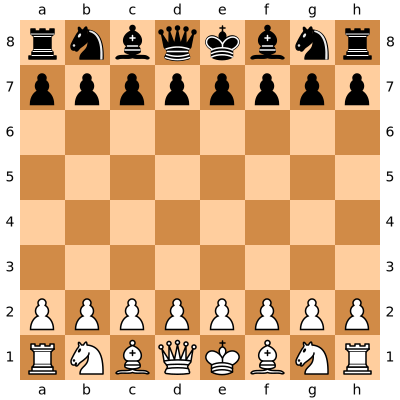

In [1]:

# On importe la librairie chess et on visualise un exemple de Board
import chess
board = chess.Board() #position initiale par defaut
board

## Representation d'une position sous forme de texte

fen est une notation pour representer les positions aux echecs:
https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation

La librairie `chess` renvoie plusieurs info en output de la methode `fen()`:
1. fen 
2. A qui le tour (w for white, b for black0
3. Information sur le status des rocks des joueurs (KQkq tout les rocks sont possibles, etc...)
4. Information sur les prises en passant (par example le charactere `-` indique qu'il n'y a pas de prises en passant sur ce tour
5. Info sur le nombre de coup depuis le debut de la partie (0 et 1 a la fin etc..)

In [3]:
fen_data = board.fen().split(" ")
print(fen_data)

['rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR', 'w', 'KQkq', '-', '0', '1']


## Representation de chaque piece d'echecs sous forme de vecteur 

Notre IA ne reconnait pas les characteres de l'alphabet, elle est + forte avec des vecteurs de nombres. Donc on va juste transformer chaque lettre associé aux pieces vers un vecteur specifique. Le tout sera stocké dans notre dictionaire `one_hot_dictionary` :
https://en.wikipedia.org/wiki/One-hot

In [4]:
## all the possibilities
one_hot_dictionary = {}
pieces = ['r', "n", "b", "q", 'k', "p"]
possibilities = pieces + [piece.upper() for piece in pieces]
print(len(possibilities))

one_hot_dictionary = {}
one_hot_dictionary["1"] = [0 for _ in range(13)]
for i, possibility in enumerate(possibilities):
    one_hot_dictionary[possibility] = [0 for _ in range(13)]
    one_hot_dictionary[possibility][i] = 1
one_hot_dictionary

12


{'1': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'B': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'K': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'N': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'P': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'Q': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'R': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'b': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'k': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'n': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'p': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'q': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'r': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

## Representation de n'importe quelle position d'echecs sous forme de matrice (tableau)

Notre ordinateur ne comprends pas les lettres, mais il comprend tres bien les matrices contenant des nombres. 

C'est exactement ce que la fonction `get_numpy_board` va faire, renvoyer une matrice a partir d'une position d'echeccs.

In [0]:
import numpy as np

def get_numpy_board(board):
    def transform_line(line):
        result = ""
        for character in line:
            if character.isdigit():
                for i in range(int(character)):
                    result += "1"
            else:
                result += character
        return result
    
    def compute_en_passant(ep_square):
        def alg_to_coord(alg):
            rank = 8 - int(alg[1])        # 0-7
            file = ord(alg[0]) - ord('a') # 0-7 #WTF ord("a")??
            return rank, file
        # renvoie une matrice de la taille dun jeu d'echec, contenant True si la case possede un 
        #pion que l'on peut manger en passant
        en_passant = np.zeros((8, 8, 1), dtype=np.bool)
        if ep_square != '-':
            eps = alg_to_coord(ep_square)
            en_passant[eps[0]][eps[1]] = True
        return en_passant

    fen_data = board.fen().split(" ")
    fen, turn, castling, ep_square, half_move_clock, fullmove_number = fen_data
    en_passant = compute_en_passant(ep_square)
    auxiliary_planes = [np.full((8, 8, 1), ('K' in castling), dtype=np.bool),
                        np.full((8, 8, 1), ('Q' in castling), dtype=np.bool),
                        np.full((8, 8, 1), ('k' in castling), dtype=np.bool),
                        np.full((8, 8, 1), ('q' in castling), dtype=np.bool),
                        en_passant]
    
    piece_information_plane = np.zeros((8,8, len(one_hot_dictionary)))
    for i, line in enumerate(fen.split("/")):
        for j, case in enumerate(transform_line(line)):
            piece_information_plane[i][j] = one_hot_dictionary[case]    
    all_planes = auxiliary_planes + [piece_information_plane]
    all_planes_numpy = np.concatenate(all_planes, axis=-1).astype(np.float32)
    return all_planes_numpy


## Calculer la liste de tout les coups possibles aux echecs

On peut voir un coup aux echec comme le deplacement d'une case vers une autre. Il faut juste connaitre la position de la case d'arrivee, et la position de la case de depart. On peut stocker l'information d'une case avec le systeme des coordonnees lettre/chiffre.

Par exemple, la chaine de caractere `a1b1` nous indique un deplacement de la piece sur la case `a1` vers la case `b1`.

In [11]:
def create_uci_labels():
    """
    Creates the labels for the universal chess interface into an array and returns them
    :return:
    """
    labels_array = []
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #indice colonnes echiquier
    numbers = ['1', '2', '3', '4', '5', '6', '7', '8'] #indice lignes echiquier
    promoted_to = ['q', 'r', 'b', 'n'] #list of the available promotion for the pawn

    for l1 in range(8):
        for n1 in range(8):
            destinations = [(t, n1) for t in range(8)] + \
                           [(l1, t) for t in range(8)] + \
                           [(l1 + t, n1 + t) for t in range(-7, 8)] + \
                           [(l1 + t, n1 - t) for t in range(-7, 8)] + \
                           [(l1 + a, n1 + b) for (a, b) in
                            [(-2, -1), (-1, -2), (-2, 1), (1, -2), (2, -1), (-1, 2), (2, 1), (1, 2)]]
            for (l2, n2) in destinations:
                if (l1, n1) != (l2, n2) and l2 in range(8) and n2 in range(8):
                    move = letters[l1] + numbers[n1] + letters[l2] + numbers[n2]
                    labels_array.append(move)
    for l1 in range(8):
        l = letters[l1]
        for p in promoted_to:
            labels_array.append(l + '2' + l + '1' + p)
            labels_array.append(l + '7' + l + '8' + p)
            if l1 > 0:
                l_l = letters[l1 - 1]
                labels_array.append(l + '2' + l_l + '1' + p)
                labels_array.append(l + '7' + l_l + '8' + p)
            if l1 < 7:
                l_r = letters[l1 + 1]
                labels_array.append(l + '2' + l_r + '1' + p)
                labels_array.append(l + '7' + l_r + '8' + p)
    return labels_array
#tout les coups possibles
all_moves = create_uci_labels()
print(all_moves)
number_moves = len(all_moves)
assert number_moves == 1968
all_planes_numpy = get_numpy_board(board)
shape_board = list(all_planes_numpy.shape)
assert shape_board == [8,8,18]
# board

['a1b1', 'a1c1', 'a1d1', 'a1e1', 'a1f1', 'a1g1', 'a1h1', 'a1a2', 'a1a3', 'a1a4', 'a1a5', 'a1a6', 'a1a7', 'a1a8', 'a1b2', 'a1c3', 'a1d4', 'a1e5', 'a1f6', 'a1g7', 'a1h8', 'a1c2', 'a1b3', 'a2b2', 'a2c2', 'a2d2', 'a2e2', 'a2f2', 'a2g2', 'a2h2', 'a2a1', 'a2a3', 'a2a4', 'a2a5', 'a2a6', 'a2a7', 'a2a8', 'a2b3', 'a2c4', 'a2d5', 'a2e6', 'a2f7', 'a2g8', 'a2b1', 'a2c1', 'a2c3', 'a2b4', 'a3b3', 'a3c3', 'a3d3', 'a3e3', 'a3f3', 'a3g3', 'a3h3', 'a3a1', 'a3a2', 'a3a4', 'a3a5', 'a3a6', 'a3a7', 'a3a8', 'a3b4', 'a3c5', 'a3d6', 'a3e7', 'a3f8', 'a3b2', 'a3c1', 'a3b1', 'a3c2', 'a3c4', 'a3b5', 'a4b4', 'a4c4', 'a4d4', 'a4e4', 'a4f4', 'a4g4', 'a4h4', 'a4a1', 'a4a2', 'a4a3', 'a4a5', 'a4a6', 'a4a7', 'a4a8', 'a4b5', 'a4c6', 'a4d7', 'a4e8', 'a4b3', 'a4c2', 'a4d1', 'a4b2', 'a4c3', 'a4c5', 'a4b6', 'a5b5', 'a5c5', 'a5d5', 'a5e5', 'a5f5', 'a5g5', 'a5h5', 'a5a1', 'a5a2', 'a5a3', 'a5a4', 'a5a6', 'a5a7', 'a5a8', 'a5b6', 'a5c7', 'a5d8', 'a5b4', 'a5c3', 'a5d2', 'a5e1', 'a5b3', 'a5c4', 'a5c6', 'a5b7', 'a6b6', 'a6c6', 'a6d6',

On remarque qu'il y a 1968 coups possible. Mais certains coup peuvent ne pas etre possible en fonction de la position du debut. Dans ce cas, il faut une methode pour determiner quel coup est valide/invalide dans cette grande liste contenant tout les coups possibles. 

C'est l'objectif de l'IA que l'on va entrainer dans 5min

In [0]:
import chess

def get_label_moves(board):
    labels = np.zeros((number_moves), dtype=np.bool)
    legal_moves = [str(x) for x in list(board.legal_moves)]
    for i, move in enumerate(all_moves):
        if str(move) in legal_moves:
            labels[i] = (1)
    return labels
def get_features(board):
    return get_numpy_board(board)
# get_features(board)

# list(get_label_moves(board))

In [14]:
%%time
board = chess.Board()

#for a given board
X = get_features(board)
y = get_label_moves(board)

CPU times: user 2.19 ms, sys: 1.04 ms, total: 3.23 ms
Wall time: 2.98 ms


In [15]:
print(board.fen())


rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1


In [0]:
def get_unique_identifier(board):
    return str(board.board_fen()) + str(board.turn) + str(board.castling_rights) + str(board.ep_square)

In [0]:
def get_moves_until_end(observations, board, dataset_size, max_number_moves):
    if len(observations) == dataset_size or max_number_moves==0:
        return
    
    if board.turn == chess.WHITE:
        identifier = get_unique_identifier(board)
        if identifier not in observations:
                observations[identifier] = [get_features(board), get_label_moves(board)]
                if len(observations) % int(dataset_size / 100) ==0:
                    print(f" {len(observations)} observations has been simulated")
    legal_moves = list(board.legal_moves)
    if not (legal_moves):
        return
    random_move = np.random.choice(legal_moves)
    board.push(random_move)
    get_moves_until_end(observations, board , dataset_size, max_number_moves-1)

In [0]:
def generate_dataset(max_number_moves=500, dataset_size=100000):
    observations = {}
    while len(observations) < dataset_size:
        board = chess.Board()
        get_moves_until_end(observations, board, dataset_size, max_number_moves)
    X = np.zeros((dataset_size, 8,8,18), dtype=np.float32)
    y = np.zeros((dataset_size, number_moves), dtype=np.int8)
    for i, obs in enumerate(observations):
        X[i] = observations[obs][0]
        y[i] = observations[obs][1] #un peu redondant
    return X, y

In [34]:
%%time
dataset_size=10*10000
X, y = generate_dataset(max_number_moves=300, dataset_size=dataset_size)

 1000 observations has been simulated
 2000 observations has been simulated
 3000 observations has been simulated
 4000 observations has been simulated
 5000 observations has been simulated
 6000 observations has been simulated
 7000 observations has been simulated
 8000 observations has been simulated
 9000 observations has been simulated
 10000 observations has been simulated
 11000 observations has been simulated
 12000 observations has been simulated
 13000 observations has been simulated
 14000 observations has been simulated
 15000 observations has been simulated
 16000 observations has been simulated
 17000 observations has been simulated
 18000 observations has been simulated
 19000 observations has been simulated
 20000 observations has been simulated
 21000 observations has been simulated
 22000 observations has been simulated
 23000 observations has been simulated
 24000 observations has been simulated
 25000 observations has been simulated
 26000 observations has been simul

In [0]:
np.save("X.npy", X)
np.save("y.npy", y)

## Est ce que j'ai tout les elements pour entrainer mon IA?

- [x] representer la position d'une partie d'echecs sous forme de matrice numpy 
- [x] la liste de tout les coups possibles pour une partie d'echecs (case a to case b etc..)
- [x] connaitre la liste des coups valides pour une position existante (`list(board.legal_moves)`)
- [x] Definition d'un mini modele qui prevoit valeur et une probabilite pour chaque coup (je fais ca maintenant)

## Definition d'un reseau de neuronne convolutionnel avec Keras (Tensorflow)

In [0]:
#import specific libraries
import keras
from keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense
from keras.models import Model


In [37]:

def model_moves():
    NUMBER_FILTERS = 64
    #take a numpy array representing a board as input, and who plays first, and then return
    # the value of a game, number between -1 and 1
    board = Input(shape=(shape_board))
    
    features = Conv2D(filters=NUMBER_FILTERS,kernel_size=3,activation="relu", padding="same")(board)
    features = BatchNormalization()(features)
    features = Conv2D(filters=NUMBER_FILTERS, kernel_size=3,activation="relu", padding="same")(features)
    features = BatchNormalization()(features)
    features = Conv2D(filters=2, kernel_size=3,activation="relu", padding="same")(features)
    print(features.shape)
    features = Flatten()(features)
    features = Dense(512, activation="relu")(features)
    features = BatchNormalization()(features)
    features = Dense(512, activation="relu")(features)
    
#     value_prediction = Dense(1, activation="sigmoid")(features) #TRY WITH TANGENT FOR output between -1 and 1
    policy_prediction = Dense(number_moves, activation="sigmoid")(features)

    model = Model(board, policy_prediction)
    model.compile(loss=["binary_crossentropy"], optimizer="Adam")
    model.summary()
    return model
model = model_moves()

(None, 8, 8, 2)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 8, 8, 18)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 64)          10432     
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 2)           1154      
_________________________________________________________________
flatten_6 (Flatten)          (None, 128)   

In [41]:
model.fit(X, y, epochs=10000, batch_size=128) # loss: 0.0344 in ~2 epochs

Epoch 1/10000
100000/100000 [==============================] - 8s 80us/step - loss: 0.0045
Epoch 2/10000
100000/100000 [==============================] - 8s 82us/step - loss: 0.0040
Epoch 3/10000
100000/100000 [==============================] - 8s 81us/step - loss: 0.0036
Epoch 4/10000
100000/100000 [==============================] - 8s 81us/step - loss: 0.0032
Epoch 5/10000
100000/100000 [==============================] - 8s 79us/step - loss: 0.0029
Epoch 6/10000
100000/100000 [==============================] - 8s 80us/step - loss: 0.0026
Epoch 7/10000
100000/100000 [==============================] - 8s 81us/step - loss: 0.0025
Epoch 8/10000
100000/100000 [==============================] - 8s 79us/step - loss: 0.0023
Epoch 9/10000
100000/100000 [==============================] - 8s 80us/step - loss: 0.0022
Epoch 10/10000
100000/100000 [==============================] - 8s 81us/step - loss: 0.0020
Epoch 11/10000
100000/100000 [==============================] - 8s 80us/step - loss: 0.00

KeyboardInterrupt: ignored

## Visualisation de la prediction du model
Le modele predit pour chaque coup:
1. un nombre entre 0 et 1 (que l'on peut interpreter en tant que probabilité)

Plus la valeur est grande, plus le modele est confiant que ce coup est valide

